<a href="https://colab.research.google.com/github/jovanape/Bitcoint-Price-Prediction/blob/main/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
# Ucitavanje biblioteka
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [71]:
# Ucitavanje skupa podataka
data = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
data

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
4857372,1617148560,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
4857373,1617148620,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
4857374,1617148680,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496
4857375,1617148740,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202


In [72]:
# Izracunavanje datuma

# Kako je Timestamp broj sekundi izmedju
# odredjenog datuma i 1. januara 1970 (UTC),
# radi citljivosti, u narednom kodu je
# Timestamp preveden u datum

data['Date'] = pd.to_datetime(data['Timestamp'], unit='s').dt.date # samo datum (bez vremena)
data.head(3)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Date
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31


Vise istih datuma - u nastavku ce biti izracunata srednja vrednost cene za svaki datum

In [73]:
group = data.groupby('Date')
data

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Date
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,2011-12-31
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31
...,...,...,...,...,...,...,...,...,...
4857372,1617148560,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339,2021-03-30
4857373,1617148620,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508,2021-03-30
4857374,1617148680,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496,2021-03-30
4857375,1617148740,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202,2021-03-30


In [74]:
mean_price = group['Weighted_Price'].mean()
mean_price

Date
2011-12-31        4.471603
2012-01-01        4.806667
2012-01-02        5.000000
2012-01-03        5.252500
2012-01-04        5.208159
                  ...     
2021-03-27    55193.357260
2021-03-28    55832.958824
2021-03-29    56913.993819
2021-03-30    58346.912268
2021-03-31    58764.349363
Name: Weighted_Price, Length: 3376, dtype: float64

In [75]:
# Podela podataka na trening i test
# mean_price - prosecna cena po danima
# Skupovi za trening i test su odatle izvedeni
# Predvidjanje se vrsi za poslednjih prediction_days dana

prediction_days = 60

train = mean_price[:len(mean_price)-prediction_days]
test = mean_price[len(mean_price)-prediction_days:]

In [14]:
train.head(3)

Date
2011-12-31    4.471603
2012-01-01    4.806667
2012-01-02    5.000000
Name: Weighted_Price, dtype: float64

In [15]:
train.values

array([4.47160287e+00, 4.80666667e+00, 5.00000000e+00, ...,
       3.17938844e+04, 3.50514678e+04, 3.40537126e+04])

### **Pretprocesiranje podataka**

In [16]:
training_set = train.values
training_set

array([4.47160287e+00, 4.80666667e+00, 5.00000000e+00, ...,
       3.17938844e+04, 3.50514678e+04, 3.40537126e+04])

In [17]:
training_set = np.reshape(training_set, (len(training_set), 1))
training_set

array([[4.47160287e+00],
       [4.80666667e+00],
       [5.00000000e+00],
       ...,
       [3.17938844e+04],
       [3.50514678e+04],
       [3.40537126e+04]])

In [18]:
# Skaliranje podataka ########### TODOTODOTODOTOODOTODOTODO Proveriti da li i y treba skalirati?!

scaler = MinMaxScaler()
training_set = scaler.fit_transform(training_set)

X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]

X_train = np.reshape(X_train, (len(X_train), 1, 1))

print('X_train:\n', X_train)
print('\n')
print('y_train:\n', y_train)

X_train:
 [[[3.46453603e-06]]

 [[1.17600344e-05]]

 [[1.65465747e-05]]

 ...

 [[7.71089056e-01]]

 [[7.87044701e-01]]

 [[8.67695843e-01]]]


y_train:
 [[1.17600344e-05]
 [1.65465747e-05]
 [2.27979614e-05]
 ...
 [7.87044701e-01]
 [8.67695843e-01]
 [8.42993453e-01]]


# **Kreiranje i treniranje mreže**

### **Kreiranje i treniranje prvog modela mreže**

In [19]:
# Inicijalizacija RNN
model = Sequential()

# Dodavanje input i LSTM sloja
model.add(LSTM(units = 4, activation = 'sigmoid', input_shape = (None, 1)))

# Dodavanje izlaznog sloja
model.add(Dense(units = 1))

# Arhitektura mreze
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4)                 96        
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Kompilacija RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy', 'mae'])

# Treniranje RNN na trening skupu
history = model.fit(X_train, y_train, batch_size = 1, epochs = 100, validation_split = 0.1, verbose = 2)

Epoch 1/100
2983/2983 - 27s - loss: 0.0061 - accuracy: 3.3523e-04 - mae: 0.0633 - val_loss: 0.0410 - val_accuracy: 0.0000e+00 - val_mae: 0.1604
Epoch 2/100
2983/2983 - 3s - loss: 0.0011 - accuracy: 3.3523e-04 - mae: 0.0244 - val_loss: 0.0036 - val_accuracy: 0.0030 - val_mae: 0.0338
Epoch 3/100
2983/2983 - 4s - loss: 2.9518e-05 - accuracy: 3.3523e-04 - mae: 0.0029 - val_loss: 0.0021 - val_accuracy: 0.0030 - val_mae: 0.0199
Epoch 4/100
2983/2983 - 4s - loss: 2.5985e-05 - accuracy: 3.3523e-04 - mae: 0.0029 - val_loss: 0.0020 - val_accuracy: 0.0030 - val_mae: 0.0195
Epoch 5/100
2983/2983 - 4s - loss: 2.6957e-05 - accuracy: 3.3523e-04 - mae: 0.0029 - val_loss: 0.0021 - val_accuracy: 0.0030 - val_mae: 0.0207
Epoch 6/100
2983/2983 - 4s - loss: 2.7627e-05 - accuracy: 3.3523e-04 - mae: 0.0030 - val_loss: 0.0022 - val_accuracy: 0.0030 - val_mae: 0.0221
Epoch 7/100
2983/2983 - 4s - loss: 2.6810e-05 - accuracy: 3.3523e-04 - mae: 0.0030 - val_loss: 0.0022 - val_accuracy: 0.0030 - val_mae: 0.0216
Ep

### **Kreiranje i treniranje drugog modela mreze**


In [21]:
# Inicijalizacija RNN
model_2 = Sequential()

# Dodavanje slojeva
model_2.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (None, 1)))
model_2.add(Dropout(0.2))
model_2.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
model_2.add(Dropout(0.3))
model_2.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model_2.add(Dropout(0.4))
model_2.add(LSTM(units = 120, activation = 'relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(units =1))

# Arhitektura mreze
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 50)          10400     
_________________________________________________________________
dropout (Dropout)            (None, None, 50)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 60)          26640     
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 60)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 80)          45120     
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 80)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 120)              

In [22]:
# Kompilacija RNN
model_2.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy', 'mae'])

# Treniranje RNN na trening skupu
history_2 = model_2.fit(X_train, y_train, batch_size = 20, epochs = 50, validation_split = 0.1, verbose = 2)

Epoch 1/50
150/150 - 11s - loss: 0.0085 - accuracy: 3.3523e-04 - mae: 0.0741 - val_loss: 0.0996 - val_accuracy: 0.0000e+00 - val_mae: 0.2531
Epoch 2/50
150/150 - 1s - loss: 0.0025 - accuracy: 3.3523e-04 - mae: 0.0334 - val_loss: 0.0030 - val_accuracy: 0.0030 - val_mae: 0.0208
Epoch 3/50
150/150 - 1s - loss: 9.0269e-04 - accuracy: 3.3523e-04 - mae: 0.0183 - val_loss: 0.0014 - val_accuracy: 0.0030 - val_mae: 0.0323
Epoch 4/50
150/150 - 1s - loss: 8.5425e-04 - accuracy: 3.3523e-04 - mae: 0.0177 - val_loss: 0.0016 - val_accuracy: 0.0030 - val_mae: 0.0314
Epoch 5/50
150/150 - 1s - loss: 7.2233e-04 - accuracy: 3.3523e-04 - mae: 0.0165 - val_loss: 0.0015 - val_accuracy: 0.0030 - val_mae: 0.0209
Epoch 6/50
150/150 - 1s - loss: 6.8057e-04 - accuracy: 3.3523e-04 - mae: 0.0160 - val_loss: 0.0053 - val_accuracy: 0.0030 - val_mae: 0.0439
Epoch 7/50
150/150 - 1s - loss: 7.4108e-04 - accuracy: 3.3523e-04 - mae: 0.0166 - val_loss: 0.0061 - val_accuracy: 0.0030 - val_mae: 0.0403
Epoch 8/50
150/150 - 1s

# **Predviđanja mreža**

### **Predvidjanje prvog modela mreže**

In [78]:
# Predvidjanje prvog modela mreze

# Skup podataka za testiranje
test_set = test.values
test_data = np.reshape(test_set, (len(test_set), 1))

test_data = np.reshape(test_data, (len(test_data), 1, 1))

# Odredjivanje ciljne promenljive
X_test = test_data[0:len(test_data)-1]
y_test = test_data[1:len(test_data)]

X_test = np.reshape(X_test, (len(X_test), 1))


# Skaliranje podataka skupa za testiranje
X_test = scaler.transform(X_test)

X_test = np.reshape(X_test, (len(X_test), 1, 1))


In [104]:
test_data[:5], test_data.shape

(array([[[33450.93785876]],
 
        [[33705.97519065]],
 
        [[34713.69640011]],
 
        [[36573.09481031]],
 
        [[37541.54813242]]]), (60, 1, 1))

In [103]:
X_test[:5], X_test.shape

(array([[[0.82806998]],
 
        [[0.83438418]],
 
        [[0.85933331]],
 
        [[0.90536823]],
 
        [[0.92934517]]]), (59, 1, 1))

In [102]:
y_test[:5], y_test.shape

(array([[[33705.97519065]],
 
        [[34713.69640011]],
 
        [[36573.09481031]],
 
        [[37541.54813242]],
 
        [[37630.049214  ]]]), (59, 1, 1))

In [101]:
y_test_reshaped = np.reshape(y_test, (len(y_test), 1))
y_test_reshaped[:5], y_test_reshaped.shape

(array([[33705.97519065],
        [34713.69640011],
        [36573.09481031],
        [37541.54813242],
        [37630.049214  ]]), (59, 1))

In [108]:
# Predvidjanje 1. modela
predicted_price = model.predict(X_test)
predicted_price[:5], predicted_price.shape

(array([[0.73349375],
        [0.73742336],
        [0.75264627],
        [0.77947414],
        [0.79280907]], dtype=float32), (59, 1))

In [105]:
# Primenjena je inverzna transformacija
# kako bi se dobila pocetna forma cene

predicted_real_price = scaler.inverse_transform(predicted_price)
predicted_real_price[:5]

array([[29630.904],
       [29789.627],
       [30404.496],
       [31488.102],
       [32026.713]], dtype=float32)

### **Predvidjanje drugog modela mreže**

In [106]:
# Predvidjanje 2. modela

# Skup podataka za testiranje isti kao kod 1. modela - X_test

predicted_price_2 = model_2.predict(X_test)
predicted_price_2[:5]

# np.reshape(predicted_price_2, (len(predicted_price_2), 1, 1))


array([[1.0718571],
       [1.0931965],
       [1.1807499],
       [1.3543867],
       [1.4507669]], dtype=float32)

In [107]:
# Primenjena je inverzna transformacija
# kako bi se dobila pocetna forma cene

predicted_real_price_2 = scaler.inverse_transform(predicted_price_2)
predicted_real_price_2[:5]

array([[43297.754],
       [44159.676],
       [47696.047],
       [54709.418],
       [58602.316]], dtype=float32)

# **Vizuelni prikaz rezultata**

### **Vizuelni prikaz rezultata prvog modela mreze**

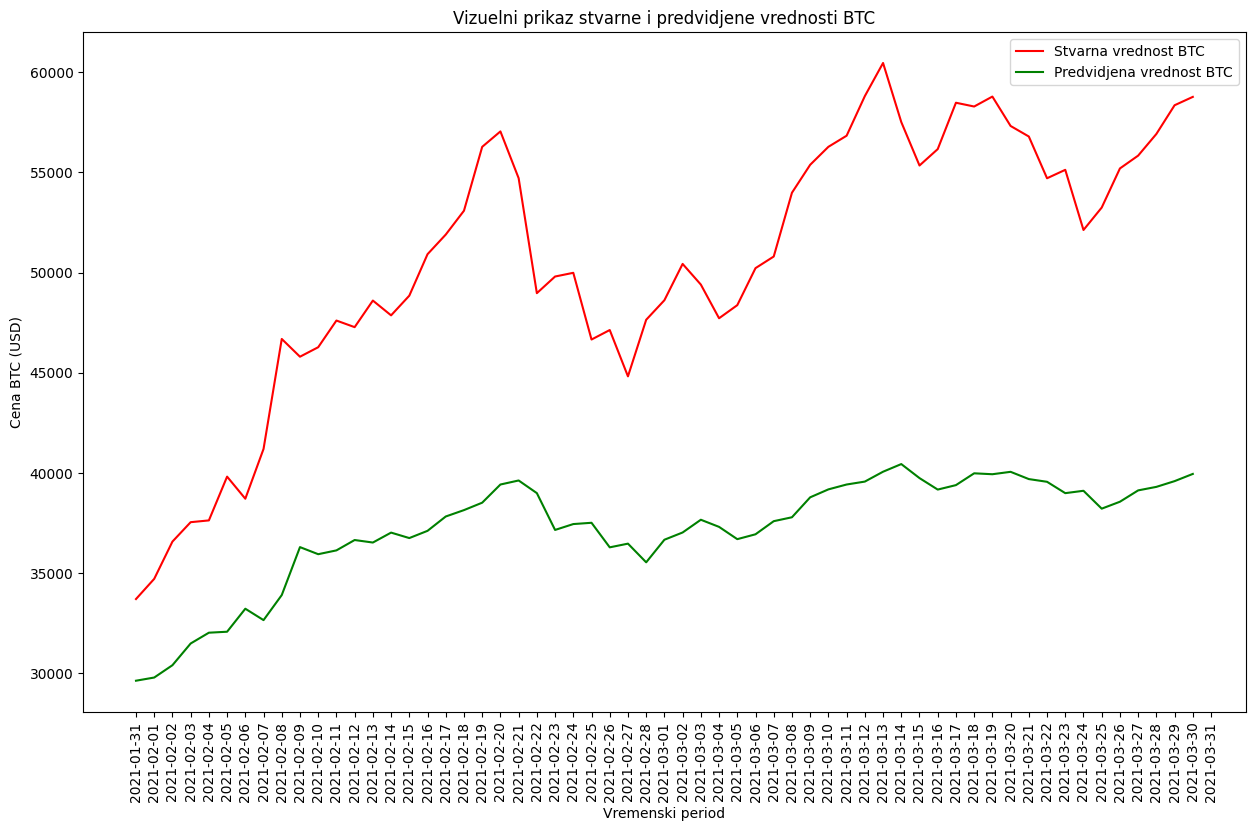

In [87]:
# Vizuelni prikaz rezultata prvog modela mreze

plt.figure(figsize=(15,9), dpi=100, facecolor='w', edgecolor='k')
ax = plt.gca()

plt.title('Vizuelni prikaz stvarne i predvidjene vrednosti BTC')
plt.plot(y_test_reshaped, color = 'red', label = 'Stvarna vrednost BTC')
plt.plot(predicted_real_price, color = 'green', label = 'Predvidjena vrednost BTC')

test = test.reset_index()
x = test.index

plt.xticks(x, labels = test['Date'], rotation = 'vertical')
plt.xlabel('Vremenski period')
plt.ylabel('Cena BTC (USD)')
plt.legend(loc='best')
plt.show()

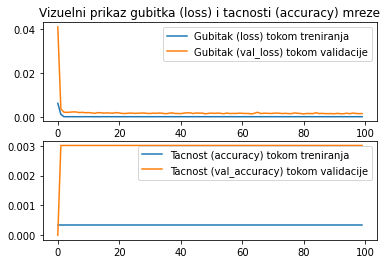

In [88]:
# Vizuelni prikaz gubitka (loss) tokom treniranja mreze

plt.subplot(211)
# plt.title('Gubitak (Loss)')
epochs = range(len(history.history['loss']))
plt.plot(epochs, history.history['loss'], label='Gubitak (loss) tokom treniranja')
plt.plot(epochs, history.history['val_loss'], label='Gubitak (val_loss) tokom validacije')

plt.legend()

plt.title('Vizuelni prikaz gubitka (loss) i tacnosti (accuracy) mreze')

# Vizuelni prikaz tacnosti (accuracy) tokom treniranja mreze
plt.subplot(212)
# plt.title('Tacnost (Accuracy)')
plt.plot(epochs, history.history['accuracy'], label='Tacnost (accuracy) tokom treniranja')
plt.plot(epochs, history.history['val_accuracy'], label='Tacnost (val_accuracy) tokom validacije')

plt.legend()

plt.show()

In [89]:
# Vizuelni prikaz MAE

def plot_mae(history_):

  epochs = range(len(history_.history['mae'])) # broj epoha
  plt.title('Vizuelni prikaz MAE (mae')
  plt.xlabel('broj epohe')
  plt.ylabel('MAE')
  
  plt.plot(epochs, history_.history['mae'], label='MAE (mae) tokom treniranja')

  if 'val_mae' in history_.history:
    plt.plot(epochs, history_.history['val_mae'], label='MAE (val_mae) tokom treniranja sa validacijom')

  plt.legend(loc = 'best')

  plt.show()

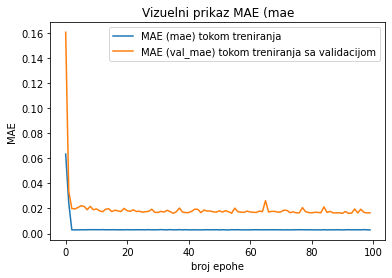

In [90]:
# MAE - sa validacijom

plot_mae(history)

In [91]:
# Loss, accuracy, MAE nad skupom za testiranje

# (za model koji pri treniranju koristi validaciju
# i za model koji pri treniranju ne koristi validaciju)

test_metrics_val = model.evaluate(X_test, y_test)

print('\n\nMetrike prilikom testiranja - model treniran sa validacijom\n')
print(model.metrics_names[0], test_metrics_val[0])
print(model.metrics_names[1], test_metrics_val[1])
print(model.metrics_names[2], test_metrics_val[2])

2/2 [==============================] - 0s 7ms/step - loss: 2601830400.0000 - accuracy: 0.0000e+00 - mae: 50573.4297


Metrike prilikom testiranja - model treniran sa validacijom

loss 2601830400.0
accuracy 0.0
mae 50573.4296875


In [92]:
# R2 skor nad skupom za testiranje

from sklearn import metrics
r2 = metrics.r2_score(predicted_real_price, y_test_reshaped)

print('R2 skor prilikom testiranja - model treniran sa validacijom', r2)

R2 skor prilikom testiranja - model treniran sa validacijom -25.45047169178611


### **Vizuelni prikaz rezultata drugog modela mreze**

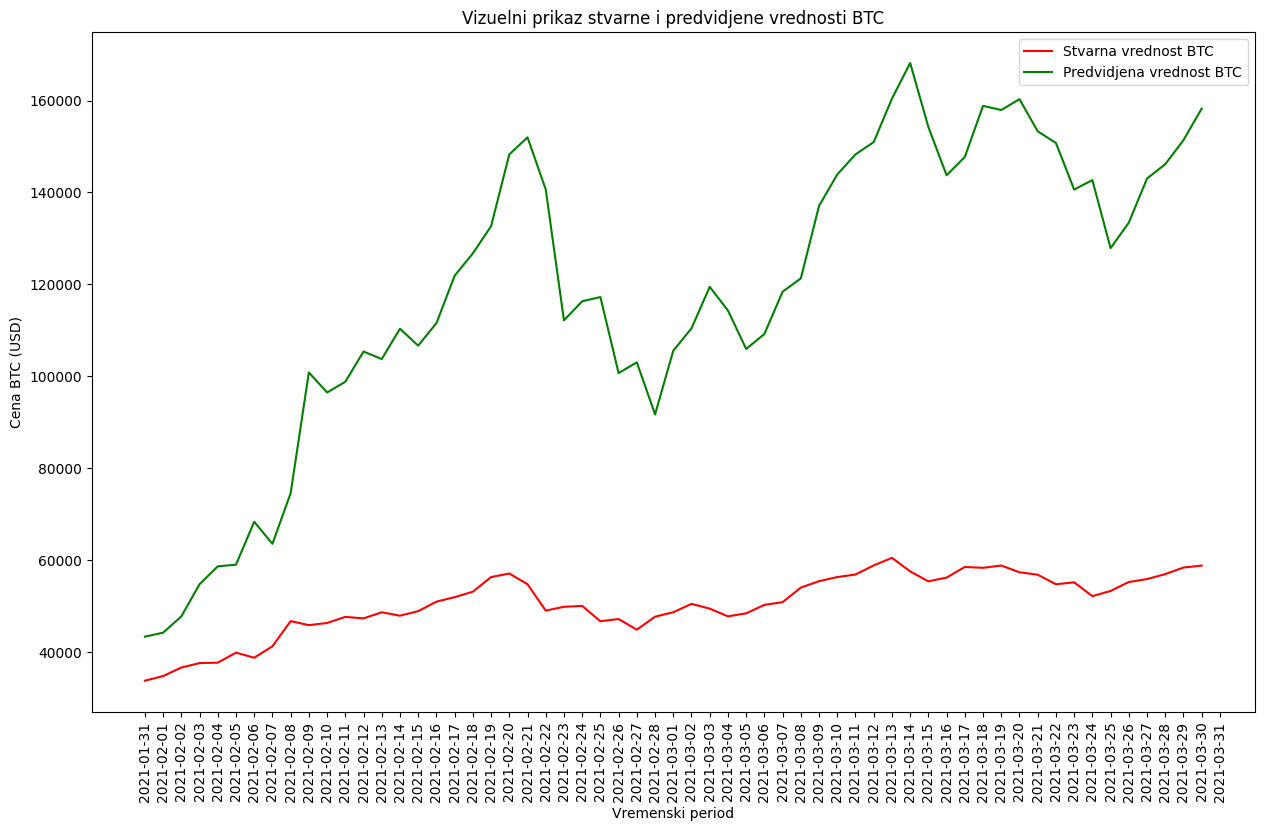

In [93]:
# Vizuelni prikaz rezultata drugog modela mreze

plt.figure(figsize=(15,9), dpi=100, facecolor='w', edgecolor='k')
ax_2 = plt.gca()

plt.title('Vizuelni prikaz stvarne i predvidjene vrednosti BTC')
plt.plot(y_test_reshaped, color = 'red', label = 'Stvarna vrednost BTC')
plt.plot(predicted_real_price_2, color = 'green', label = 'Predvidjena vrednost BTC')

test = test.reset_index()
x = test.index

plt.xticks(x, labels = test['Date'], rotation = 'vertical')
plt.xlabel('Vremenski period')
plt.ylabel('Cena BTC (USD)')
plt.legend(loc='best')
plt.show()

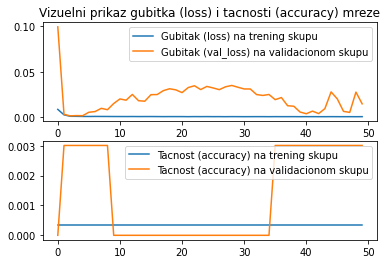

In [94]:
# Vizuelni prikaz gubitka (loss) tokom treniranja i validacije mreze

plt.subplot(211)
# plt.title('Gubitak (Loss)')
epochs = range(len(history_2.history['loss']))
plt.plot(epochs, history_2.history['loss'], label = 'Gubitak (loss) na trening skupu')
plt.plot(epochs, history_2.history['val_loss'], label = 'Gubitak (val_loss) na validacionom skupu')
plt.legend()

plt.title('Vizuelni prikaz gubitka (loss) i tacnosti (accuracy) mreze')

# Vizuelni prikaz tacnosti (accuracy) tokom treniranja i validacije mreze

plt.subplot(212)
# plt.title('Tacnost (Accuracy)')
plt.plot(epochs, history_2.history['accuracy'], label = 'Tacnost (accuracy) na trening skupu')
plt.plot(epochs, history_2.history['val_accuracy'], label = 'Tacnost (accuracy) na validacionom skupu')
plt.legend()

plt.show()

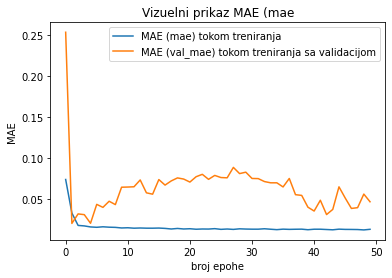

In [95]:
# MAE - sa validacijom

plot_mae(history_2)

In [96]:
# Loss, accuracy, MAE nad skupom za testiranje

# (za model koji pri treniranju koristi validaciju
# i za model koji pri treniranju ne koristi validaciju)

test_metrics_val_2 = model_2.evaluate(X_test, y_test)

print('\n\nMetrike prilikom testiranja - model treniran sa validacijom\n')
print(model_2.metrics_names[0], test_metrics_val_2[0])
print(model_2.metrics_names[1], test_metrics_val_2[1])
print(model_2.metrics_names[2], test_metrics_val_2[2])

2/2 [==============================] - 0s 8ms/step - loss: 2601617152.0000 - accuracy: 0.0000e+00 - mae: 50571.4180


Metrike prilikom testiranja - model treniran sa validacijom

loss 2601617152.0
accuracy 0.0
mae 50571.41796875


In [97]:
# R2 skor nad skupom za testiranje

r2_2 = metrics.r2_score(predicted_real_price_2, y_test_reshaped)

print('R2 skor prilikom testiranja - model treniran sa validacijom', r2)

R2 skor prilikom testiranja - model treniran sa validacijom -25.45047169178611
